In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os.path

cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
print(src)
print(root)
sys.path.append(str(src))
sys.path.append(str(root))

/Users/matskerver/Documents/GIT/MDP_git/Git_mdp
/Users/matskerver/Documents/GIT/MDP_git


In [2]:
from superflexpy.implementation.elements.gr4j import BaseElement, UnitHydrograph1, UnitHydrograph2, FluxAggregator 
from superflexpy.implementation.elements.gr4j import InterceptionFilter, ProductionStore, RoutingStore
from superflexpy.implementation.elements.structure_elements import Transparent, Splitter, Junction
from superflexpy.implementation.root_finders.pegasus import PegasusPython
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network
from utils.precipitation_evaporation import *

In [24]:
def GR4J_element(x1,x2,x3,x4, name, area, precipitation, evaporation):
    #x1, x2, x3, x4 = (50.0, 0.1, 20.0, 3.5)

    root_finder = PegasusPython()  # Use the default parameters
    numerical_approximation = ImplicitEulerPython(root_finder)

    interception_filter = InterceptionFilter(id='ir')

    production_store = ProductionStore(parameters={'x1': x1, 'alpha': 2.0,
                                                   'beta': 5.0, 'ni': 4/9},
                                       states={'S0': 10.0},
                                       approximation=numerical_approximation,
                                       id='ps')

    splitter = Splitter(weight=[[0.9], [0.1]],
                        direction=[[0], [0]],
                        id='spl')

    unit_hydrograph_1 = UnitHydrograph1(parameters={'lag-time': x4},
                                        states={'lag': None},
                                        id='uh1')

    unit_hydrograph_2 = UnitHydrograph2(parameters={'lag-time': 2*x4},
                                        states={'lag': None},
                                        id='uh2')

    routing_store = RoutingStore(parameters={'x2': x2, 'x3': x3,
                                             'gamma': 5.0, 'omega': 3.5},
                                 states={'S0': 10.0},
                                 approximation=numerical_approximation,
                                 id='rs')

    transparent = Transparent(id='tr')

    junction = Junction(direction=[[0, None],  # First output
                                   [1, None],  # Second output
                                   [None, 0]], # Third output
                        id='jun')

    flux_aggregator = FluxAggregator(id='fa')

    catchment_element = Unit(layers=[[interception_filter],
                     [production_store],
                     [splitter],
                     [unit_hydrograph_1, unit_hydrograph_2],
                     [routing_store, transparent],
                     [junction],
                     [flux_aggregator]],
             id=f'unit-{name}')
    
    
    current_node = Node(
    units=[catchment_element],
    weights = [1.0],
    area=area,
    id=f'node-{name}'
    )
    
    current_node.set_input([precipitation, evaporation])
    #print(precipitation)
    return current_node

In [25]:
x1, x2, x3, x4 = (50.0, 0.1, 20.0, 3.5)
areas = [1.0, 4.6, 2.6, 9.1]


In [26]:
nodes_gr4j = []


for i in range(4):
    name = str(i+1)
    evaporation, precipitation = precipitation_evaporation(1, 0.2, season = True, plot = False)
    current = GR4J_element(x1, x2, x3, x4, name, areas[i], precipitation, evaporation)
    nodes_gr4j.append(current)
    #print(current.id)
    
#print(type(nodes_gr4j[0]))

In [27]:
net = Network(
    nodes=nodes_gr4j,
    topology={
        'node-1': 'node-3',
        'node-2': 'node-3',
        'node-3': 'node-4',
        'node-4': None
    }
)

In [35]:
net.reset_states()
net.set_timestep(1.0)
output = net.get_output()
print(output)

{'node-1': [array([0.14465531, 0.13449254, 0.12552368, 0.11755689, 0.11043735,
       0.10404245, 0.09827112, 0.09303994, 0.08827981, 0.08393244,
       0.07994856, 0.07628626, 0.07291337, 0.06980797, 0.06694727,
       0.06427972, 0.06177136, 0.05943441, 0.05726239, 0.0552457 ,
       0.05334336, 0.05153012, 0.04984375, 0.04832738, 0.04699821,
       0.04568673, 0.04430714, 0.04301506, 0.04181046, 0.04065471,
       0.03952588, 0.03845124, 0.03742729, 0.03645107, 0.0355197 ,
       0.03462922, 0.03377644, 0.03296007, 0.03217791, 0.03142794,
       0.03070908, 0.03002158, 0.02936486, 0.02873131, 0.02812347,
       0.02756399, 0.02706125, 0.0265578 , 0.02602196, 0.02550509,
       0.02501329, 0.02457378, 0.02422165, 0.0239764 , 0.02387183,
       0.02415276, 0.02573825, 0.02598978, 0.02609326, 0.02427722,
       0.02370417, 0.02331763, 0.02299985, 0.02266314, 0.0222584 ,
       0.02186606, 0.02152985, 0.02136393, 0.02152634, 0.02370057,
       0.02634711, 0.03005415, 0.03094543, 0.02985

In [29]:
output_unit_1_node_1 = net.call_internal(id='node-1_unit-1',
                                        method='get_output',
                                        solve=False)[0]
output_unit_2_node_2 = net.call_internal(id='node-2_unit-2',
                                        method='get_output',
                                        solve=False)[0]
output_unit_3_node_3 = net.call_internal(id='node-3_unit-3',
                                        method='get_output',
                                        solve=False)[0]
output_unit_4_node_4 = net.call_internal(id='node-4_unit-4',
                                        method='get_output',
                                        solve=False)[0]




TypeError: unhashable type: 'dict'

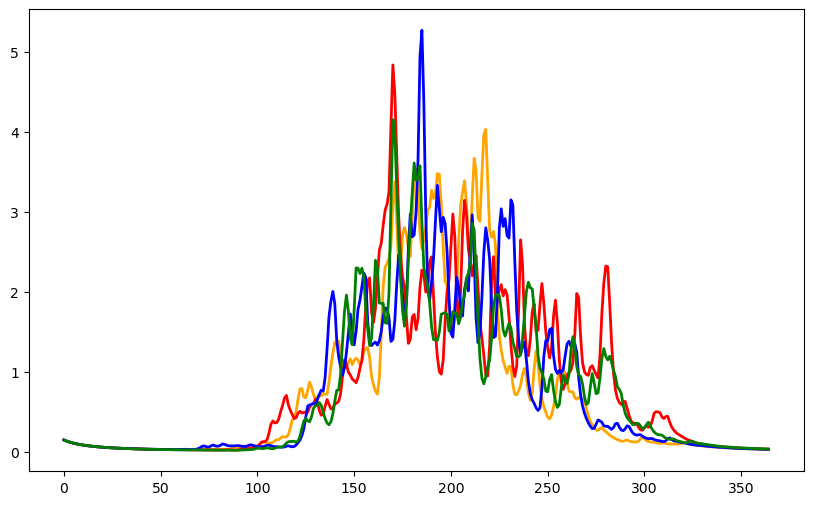

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

# Plotting each node's outflow
ax.plot(range(len(output_unit_1_node_1)), output_unit_1_node_1, color='orange', lw=2, label='Node 1')
ax.plot(range(len(output_unit_2_node_2)), output_unit_2_node_2, color='red', lw=2, label='Node 2')
ax.plot(range(len(output_unit_3_node_3)), output_unit_3_node_3, color='blue', lw=2, label='Node 3')
ax.plot(range(len(output_unit_4_node_4)), output_unit_4_node_4, color='green', lw=2, label='Node 4')
ax.plot(range(len(output)), output, color='pink', lw=2, label='Network')

ax.legend()
ax.set_xlabel('Time [days]')
ax.set_ylabel("Outflow [mm/day]")

plt.show()
